1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?
  - CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.

2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?
  - 각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음

3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?
  - 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

In [4]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [12]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, size=[224, 224, 3])
    return image, label

In [5]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
def augment2(image,label):
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_brightness(image, 0.2)
    return image, label

In [7]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

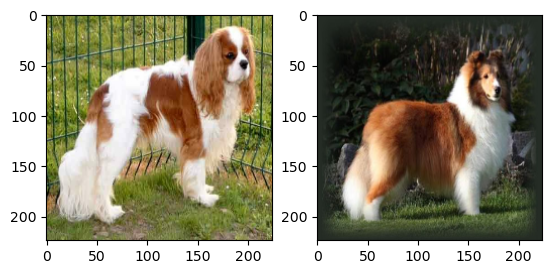

In [8]:
import matplotlib.pyplot as plt

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [9]:
def get_clip_box(image_a, image_b):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(44, shape=(), dtype=int32) tf.Tensor(182, shape=(), dtype=int32)
y :  tf.Tensor(94, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


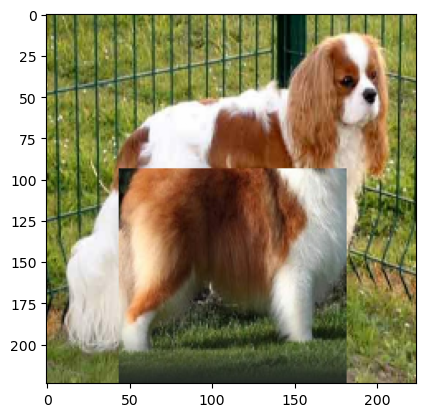

In [10]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :]
    middle_center = image_b[y_min:y_max, x_min:x_max, :]
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [11]:
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.64245856, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [12]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [13]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)

In [14]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [6]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_cutmix = apply_normalize_on_dataset(ds_train, is_test=False, with_aug=False, with_cutmix=True, with_mixup=False)
ds_mixup = apply_normalize_on_dataset(ds_train, is_test=False, with_aug=False, with_cutmix=False, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [8]:
EPOCH = 15

In [18]:
history_cutmix = resnet50.fit(
    ds_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 107s 132ms/step - loss: 3.7726 - accuracy: 0.2262 - val_loss: 3.3495 - val_accuracy: 0.2119
Epoch 2/15
750/750 [==============================] - 99s 132ms/step - loss: 2.9216 - accuracy: 0.4410 - val_loss: 1.5750 - val_accuracy: 0.5670
Epoch 3/15
750/750 [==============================] - 101s 135ms/step - loss: 2.6138 - accuracy: 0.5443 - val_loss: 1.3220 - val_accuracy: 0.6333
Epoch 4/15
750/750 [==============================] - 101s 135ms/step - loss: 2.4245 - accuracy: 0.5965 - val_loss: 1.2865 - val_accuracy: 0.6477
Epoch 5/15
750/750 [==============================] - 102s 136ms/step - loss: 2.2574 - accuracy: 0.6579 - val_loss: 1.2664 - val_accuracy: 0.6666
Epoch 6/15
750/750 [==============================] - 102s 137ms/step - loss: 2.1360 - accuracy: 0.6925 - val_loss: 1.2037 - val_accuracy: 0.6779
Epoch 7/15
750/750 [==============================] - 102s 136ms/step - loss: 2.0605 - accuracy: 0.7179 - val_loss: 1.2429 - 

In [19]:
resnet50_mix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_mix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [20]:
history_mixup = resnet50_mix.fit(
    ds_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 102s 131ms/step - loss: 3.7395 - accuracy: 0.2383 - val_loss: 4.3749 - val_accuracy: 0.1053
Epoch 2/15
750/750 [==============================] - 98s 131ms/step - loss: 2.9015 - accuracy: 0.4688 - val_loss: 1.5280 - val_accuracy: 0.5815
Epoch 3/15
750/750 [==============================] - 98s 131ms/step - loss: 2.5971 - accuracy: 0.5727 - val_loss: 1.8766 - val_accuracy: 0.4956
Epoch 4/15
750/750 [==============================] - 98s 131ms/step - loss: 2.4471 - accuracy: 0.6393 - val_loss: 1.1804 - val_accuracy: 0.6688
Epoch 5/15
750/750 [==============================] - 97s 130ms/step - loss: 2.3043 - accuracy: 0.6913 - val_loss: 1.2277 - val_accuracy: 0.6565
Epoch 6/15
750/750 [==============================] - 97s 129ms/step - loss: 2.1793 - accuracy: 0.7333 - val_loss: 1.3408 - val_accuracy: 0.6379
Epoch 7/15
750/750 [==============================] - 96s 128ms/step - loss: 2.1286 - accuracy: 0.7527 - val_loss: 1.3525 - val_a

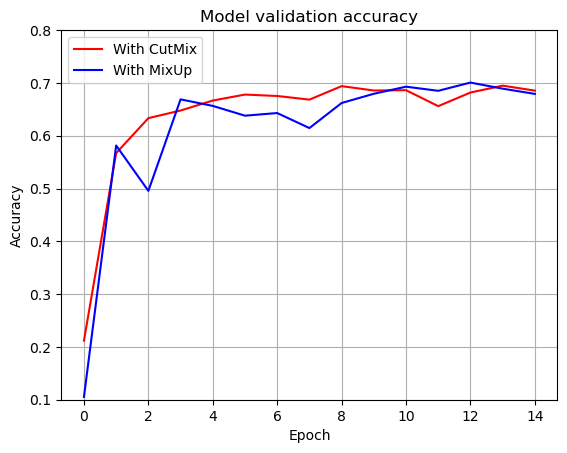

In [22]:
plt.plot(history_cutmix.history['val_accuracy'], 'r')
plt.plot(history_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With CutMix', 'With MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.1, 0.8)
plt.show()

CutMix와 MixUp의 비교 실험에서, 9 epoch 까지는 전반적으로 CutMix가 더 나은 성능을 보여주고 있음을 확인할 수 있었지만, 학습이 더 진행될수록 두 모델의 성능 차이는 점차 줄어들었다.

만약 학습할 수 있는 데이터의 양이 더 충분하였더라면 두 모델의 분명한 성능 차를 기대할 수 있을 것 같다.

CutMix와 Mixup을 비교하였으니 이제 다양한 Augmentation 기법들을 적용한 모델들의 성능을 비교해보자.

앞의 코드에서는 좌우반전 및 무작위 분할을 하는 augment()와 명도, 색상, 채도를 조절한 augment2() 함수를 구현하였다.

각각의 함수를 적용한 데이터로 훈련된 모델의 성능을 비교해보자.

In [7]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

In [13]:
num_classes = ds_info.features["label"].num_classes
def onehot_(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_and_aug(ds, is_test=False, batch_size=16, with_aug1=False, with_aug2=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug1:
        ds = ds.map(
            augment,
            num_parallel_calls=2
        )
    elif not is_test and with_aug2:
        ds = ds.map(
            augment2,
            num_parallel_calls=2
        )
    ds = ds.map(
        onehot_,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
ds_aug1 = apply_normalize_and_aug(ds_train, is_test=False, batch_size=16, with_aug1=True, with_aug2=False)
ds_aug2 = apply_normalize_and_aug(ds_train, is_test=False, batch_size=16, with_aug1=False, with_aug2=True)
ds_aug_test = apply_normalize_and_aug(ds_test, is_test=True)

In [15]:
resnet50_aug1 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_aug1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [16]:
history_aug1 = resnet50_aug1.fit(
    ds_aug1,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_aug_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 97s 120ms/step - loss: 2.2172 - accuracy: 0.4410 - val_loss: 3.1841 - val_accuracy: 0.2435
Epoch 2/15
750/750 [==============================] - 91s 121ms/step - loss: 0.8934 - accuracy: 0.7439 - val_loss: 1.5088 - val_accuracy: 0.5876
Epoch 3/15
750/750 [==============================] - 90s 119ms/step - loss: 0.4967 - accuracy: 0.8602 - val_loss: 1.1258 - val_accuracy: 0.6760
Epoch 4/15
750/750 [==============================] - 90s 120ms/step - loss: 0.2859 - accuracy: 0.9301 - val_loss: 1.0880 - val_accuracy: 0.6959
Epoch 5/15
750/750 [==============================] - 93s 124ms/step - loss: 0.1740 - accuracy: 0.9616 - val_loss: 0.9904 - val_accuracy: 0.7197
Epoch 6/15
750/750 [==============================] - 97s 129ms/step - loss: 0.0817 - accuracy: 0.9869 - val_loss: 0.9220 - val_accuracy: 0.7416
Epoch 7/15
750/750 [==============================] - 95s 127ms/step - loss: 0.0537 - accuracy: 0.9918 - val_loss: 0.9183 - val_ac

In [17]:
resnet50_aug2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_aug2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [18]:
history_aug2 = resnet50_aug2.fit(
    ds_aug2,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_aug_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 104s 134ms/step - loss: 2.5461 - accuracy: 0.3701 - val_loss: 2.0672 - val_accuracy: 0.4419
Epoch 2/15
750/750 [==============================] - 99s 133ms/step - loss: 1.1094 - accuracy: 0.6787 - val_loss: 1.7302 - val_accuracy: 0.5218
Epoch 3/15
750/750 [==============================] - 100s 133ms/step - loss: 0.6154 - accuracy: 0.8244 - val_loss: 1.3465 - val_accuracy: 0.6236
Epoch 4/15
750/750 [==============================] - 95s 126ms/step - loss: 0.3029 - accuracy: 0.9252 - val_loss: 1.3517 - val_accuracy: 0.6397
Epoch 5/15
750/750 [==============================] - 93s 124ms/step - loss: 0.1393 - accuracy: 0.9747 - val_loss: 1.2346 - val_accuracy: 0.6639
Epoch 6/15
750/750 [==============================] - 92s 123ms/step - loss: 0.0663 - accuracy: 0.9918 - val_loss: 1.2218 - val_accuracy: 0.6746
Epoch 7/15
750/750 [==============================] - 94s 126ms/step - loss: 0.0346 - accuracy: 0.9975 - val_loss: 1.2438 - val_

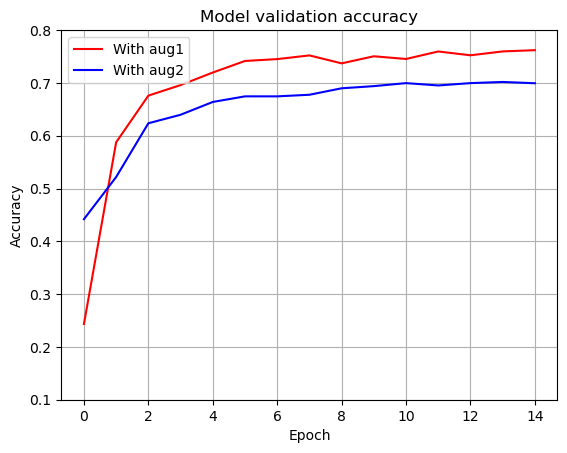

In [20]:
plt.plot(history_aug1.history['val_accuracy'], 'r')
plt.plot(history_aug2.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With aug1', 'With aug2'], loc='upper left')
plt.grid(True)
plt.ylim(0.1, 0.8)
plt.show()

결과를 보면, 좌우반전과 무작위 분할을 하는 augment() 함수를 적용한 데이터로 훈련된 모델이 더 나은 성능을 보여주었다. 또한 앞서 실험하였던 CutMix와 MixUp 모델들보다도 높은 검증 정확도를 보여준다.

결론적으로, CutMix나 MixUp 등이 다른 Augmentation 기법보다 분명한 성능 차이를 보이려면 충분한 epoch로 모델을 학습시켜야 하며, 이미지의 RGB 값을 변형한 데이터보다 이미지 자체의 크기나 픽셀의 위치 등을 변경한 데이터로 모델을 훈련시키는 것이 더 나은 성능을 기대할 수 있다.